# Notebook: Housing Prices Prediction

Table of Contents:
1. Inspecting data (define X, y columns; basics explorations)
2. Train/test data split
3. Feature Engineering
4. Modeling (including comparing Linear vs Random Forest regressions, building models with cross-validation)
5. Conclusions
6. Next steps

# 1. Inspecting data

In [1]:
import numpy as np
import pandas as pd

In [2]:
mycsv = 'data/housing.csv'
df = pd.read_csv(mycsv)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df.shape

(20640, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


# 1.1 Inspecting Data: Define X,Y columns
* X: feature columns = {numeric columns, categorical columns}
* y: target column

In [5]:
columns = list(df.columns)
print(columns)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


In [6]:
numeric_columns = columns[:-2]
cat_columns = [columns[-1]]
y_column = "median_house_value"
print("Features/num columns:\n", numeric_columns)
print("Feature/cat columns:\n", cat_columns)
print("Target column:\n", y_column)

Features/num columns:
 ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
Feature/cat columns:
 ['ocean_proximity']
Target column:
 median_house_value


# 1.2 Inspecting Data: Basic Exploration

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

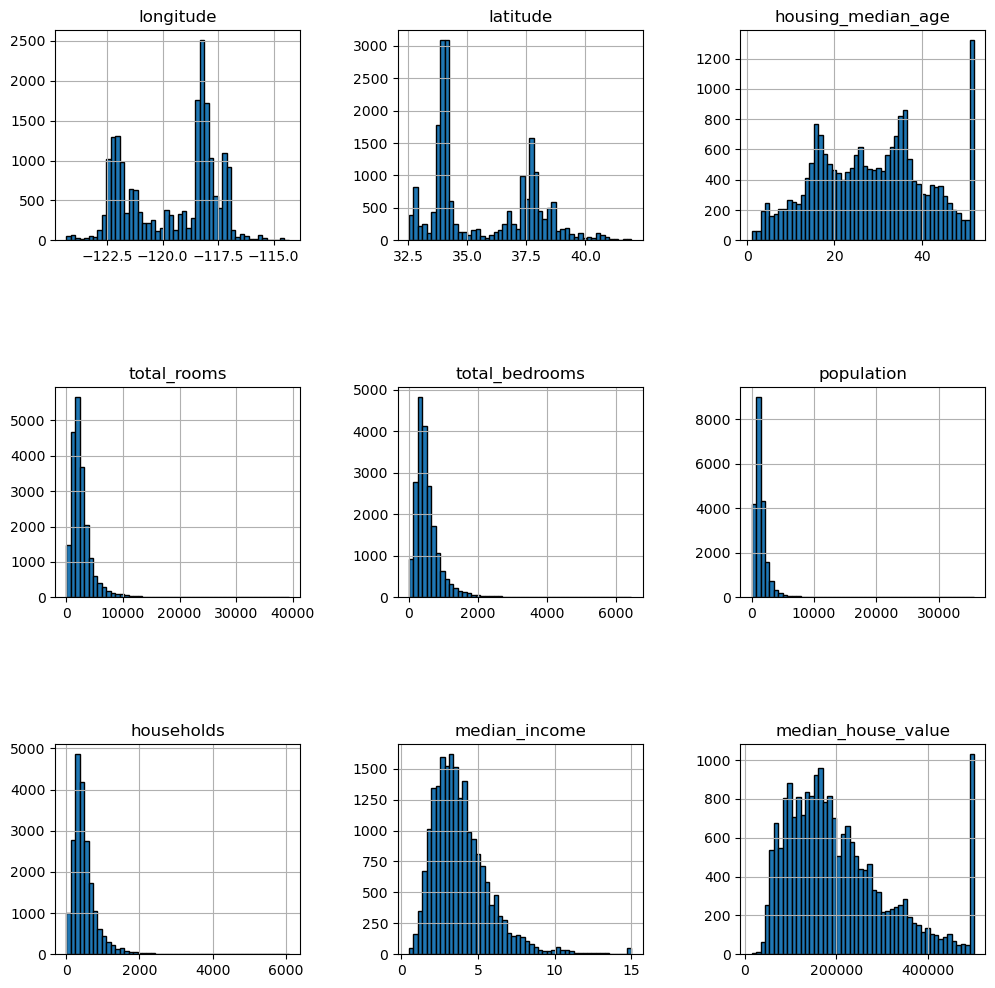

In [8]:
df[numeric_columns + [y_column]].hist(figsize=(12, 12), bins=50, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

# 1.2.1. Basic Exploration: Linear Correlations between Num Columns and Target Column

In [9]:
correlation_matrix = df[numeric_columns + [y_column]].corr()
correlation_matrix[y_column].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

# 1.2.2. Basic Exploration: Cat Columns

In [11]:
df[cat_columns].value_counts()

ocean_proximity
<1H OCEAN          9136
INLAND             6551
NEAR OCEAN         2658
NEAR BAY           2290
ISLAND                5
Name: count, dtype: int64

# 1.2.3. Basic Exploration: Missing Data. Is it serious?

In [12]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

# The Heart: from Data to Models to Predictions

Here, we will train models using two different algorithms: 
* Linear regression with regularization, Lasso
* Random forest regression

Then, 
* Comparing cross-validation (CV) performance of models from the two algorithms
* Settling down with the winning algorithm and building model artifacts based on that

# 2. Training/Test data split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
RANDOM_STATE = 123
TEST_SIZE = 0.2

In [16]:
def get_train_test_x_y(df:pd.DataFrame, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    x_train = train_df[numeric_columns + cat_columns]
    y_train = train_df[y_column]
    x_test = test_df[numeric_columns + cat_columns]
    y_test = test_df[y_column]
    return x_train, y_train, x_test, y_test

In [17]:
x_train, y_train, x_test, y_test = get_train_test_x_y(df)
print("x_train:", x_train.shape)
print("y_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

x_train: (16512, 9)
y_train: (16512, 9)
x_test: (4128, 9)
y_test: (4128,)


# 3. Feature Engineering
Objective: create a feature-transformer object that transforms raw X_train, X_test

In [18]:
# For num features
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# For cat features
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [24]:
def get_feature_transformer(x_train:pd.DataFrame):
    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("std_scaler", StandardScaler())
    ])
    
    full_pipeline=ColumnTransformer([
        ('num', num_pipeline, numeric_columns),
        ('cat', OneHotEncoder(), cat_columns)
    ])
    
    full_pipeline.fit_transform(x_train)
    
    return full_pipeline

In [38]:
feature_transformer = get_feature_transformer(x_train)
features = feature_transformer.get_feature_names_out()
print(f"After transform, there are {len(features)} features:\n", features)

After transform, there are 13 features:
 ['num__longitude' 'num__latitude' 'num__housing_median_age'
 'num__total_rooms' 'num__total_bedrooms' 'num__population'
 'num__households' 'num__median_income' 'cat__ocean_proximity_<1H OCEAN'
 'cat__ocean_proximity_INLAND' 'cat__ocean_proximity_ISLAND'
 'cat__ocean_proximity_NEAR BAY' 'cat__ocean_proximity_NEAR OCEAN']


In [39]:
transformed_x_train = feature_transformer.transform(x_train)
print(transformed_x_train.shape)

(16512, 13)


# 4. Modeling

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

# 4.1. Pre-Modeling experiments: which of the two regression algorithms works better, Lasso (regularized Linear Regression) or Random Forest?

## Will do 5-fold cross-validation

In [42]:
CV = 5

In [56]:
import warnings
warnings.filterwarnings('ignore')

## Experiment set-up: get cross-validation (CV) metrics from Lasso and Random Forest

In [48]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

In [73]:
# CV-fold cross-validation
CV = 5

In [52]:
N_EXPERIMENTS = 5

In [53]:
RANDOM_STATES = np.random.randint(0, 100, N_EXPERIMENTS)
RANDOM_STATES

array([26, 59, 78, 16, 93])

In [58]:
def get_cv_train_rmse_mae(
    model_class:str, 
    cv:int=CV, 
    n_experiments:int=N_EXPERIMENTS,
    random_states:"List[int] of length n_experiments"=RANDOM_STATES
) -> "List[int]":
    if model_class.lower() == "lasso":
        reg_model = Lasso()
    if model_class.lower() == "randomforest":
        reg_model = RandomForestRegressor()

    train_rmse = [0.0] * n_experiments
    train_mae = [0.0] * n_experiments
    test_rmse = [0.0] * n_experiments
    test_mae = [0.0] * n_experiments
    
    for i in range(n_experiments):
        x_train, y_train, x_test, y_test = get_train_test_x_y(df, random_state=random_states[i])
        
        feature_transformer = get_feature_transformer(x_train)
        
        transformed_x_train = feature_transformer.transform(x_train)
        
        reg_scores = cross_val_score(reg_model, transformed_x_train, y_train, scoring='neg_mean_squared_error', cv=cv)
        train_rmse[i] = np.sqrt(-reg_scores.mean())

        reg_scores=cross_val_score(reg_model, transformed_x_train, y_train, scoring='neg_mean_absolute_error', cv=cv)
        train_mae[i] = -reg_scores.mean()

    return {"train_rmse": train_rmse, "train_mae": train_mae}

In [59]:
lasso_cv_metrics = get_cv_train_rmse_mae("lasso")

In [60]:
forest_cv_metrics = get_cv_train_rmse_mae("randomforest")

In [64]:
print("Lasso regression:")
print(lasso_cv_metrics)
print("Random Forest regression:")
print(forest_cv_metrics)

Lasso regression:
{'train_rmse': [69335.29106522657, 69244.47427886889, 69085.33095234899, 68609.77538339482, 69068.04777219422], 'train_mae': [50070.4827298464, 50030.33825303199, 49944.77441737708, 49964.73999277492, 50022.066994883615]}
Random Forest regression:
{'train_rmse': [49377.12748252578, 49380.265901945524, 49586.65237063296, 49778.0672840542, 49819.31350553705], 'train_mae': [32118.778635725128, 32337.593139164826, 32223.577921248838, 32552.66007190974, 32436.120594123728]}


## `Experiment conclusion`: from the results, it seems `Random Forest` regression outperforms/wins over Lasso

In [70]:
print("Lasso regression:")
print("RMSE = root mean squared error, MAE = mean absolute error")
mu, sigma = np.mean(lasso_cv_metrics["train_rmse"]), np.std(lasso_cv_metrics["train_rmse"])
print(f"Train RMSE: {mu:.4f} +/- {sigma:.4f}")
mu, sigma = np.mean(lasso_cv_metrics["train_mae"]), np.std(lasso_cv_metrics["train_mae"])
print(f"Train MAE: {mu:.4f} +/- {sigma:.4f}")

Lasso regression:
RMSE = root mean squared error, MAE = mean absolute error
Train RMSE: 69068.5839 +/- 250.1424
Train MAE: 50006.4805 +/- 45.7347


In [71]:
print("Random Forest regression:")
print("RMSE = root mean squared error, MAE = mean absolute error")
mu, sigma = np.mean(forest_cv_metrics["train_rmse"]), np.std(forest_cv_metrics["train_rmse"])
print(f"Train RMSE: {mu:.4f} +/- {sigma:.4f}")
mu, sigma = np.mean(forest_cv_metrics["train_mae"]), np.std(forest_cv_metrics["train_mae"])
print(f"Train MAE: {mu:.4f} +/- {sigma:.4f}")

Random Forest regression:
RMSE = root mean squared error, MAE = mean absolute error
Train RMSE: 49588.2853 +/- 188.2836
Train MAE: 32333.7461 +/- 152.8180


# 4.2. Build Random Forest Regressor with Grid Search Cross-Validation
(since we found Random Forest at least beats Lasso)

with an added training element: use Grid Search Cross Validation to find the optimal model hyperparams

In [72]:
from sklearn.model_selection import GridSearchCV

In [74]:
forest_reg = RandomForestRegressor()

param_grid=[
    {'n_estimators': [10, 30, 100], 'max_features':[4, 6, 8, 10]},
    {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]}
]

grid_search = GridSearchCV(
    forest_reg, param_grid, cv=CV, scoring='neg_mean_absolute_error', return_train_score=True
)

grid_search.fit(transformed_x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [4, 6, 8, 10],
                          'n_estimators': [10, 30, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_absolute_error')

### Just curious: what turned out to be the best hyperparams for Random Forest regressor

In [75]:
grid_search.best_params_

{'max_features': 10, 'n_estimators': 100}

## 4.3. Get the model's test performance

In [102]:
final_model=grid_search.best_estimator_

In [103]:
transformed_x_test = feature_transformer.transform(x_test)
y_test_pred = final_model.predict(transformed_x_test)

In [104]:
test_rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_test_pred))
test_mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)

In [105]:
print("RMSE = root mean squared error, MAE = mean absolute error")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

RMSE = root mean squared error, MAE = mean absolute error
Test RMSE: 46857.9324
Test MAE: 30764.8299


### Interpretation of Test Performance test_mae = 30765:
On average, the absolute error between predicted and actual house price is $30765

# 4.4. What can the Random Forest regression model tell us about feature importance?

It is interesting to see:
1. Both linear correlation and Random Forest regressor (a non-linear model) identify `median_income` as the most important feature
2. Linear correlation gives geo-location (longitude, latitude) weak importance, but Random Forest gives them higher importance.

In [113]:
feature_importances = grid_search.best_estimator_.feature_importances_

cat_encoder = feature_transformer.named_transformers_["cat"]
cat_one_hot_features = list(cat_encoder.categories_[0])
features = numeric_columns + cat_one_hot_features

df_feature_importance = pd.DataFrame(sorted(zip(feature_importances, features), reverse=True))
df_feature_importance.columns = ['Feature', 'Importance']
df_feature_importance

,Feature,Importance
0,0.462840,median_income
1,0.155850,INLAND
2,0.109420,longitude
3,0.103742,latitude
4,0.048905,housing_median_age
5,0.033307,population
6,0.026229,total_rooms
7,0.023891,total_bedrooms
8,0.021437,households
9,0.006482,NEAR OCEAN


# 5. Conclusions

## Conclusion 0:
For this dataset, Random Forest regression seems outperforms Linear Regression

## Conclusion 1:
The test performance is consistent with, or within the boundary of, previously estimated RMSE/MAE via cross-validation. 
Recall: we estimated that RMSE: 49588.2853 +/- 188.2836, MAE: 32333.7461 +/- 152.8180

Also, if you compare with the fluctuaion of the actual housing prices, the test performance is well within the actual fluctuation. See below, the `std` value

In [112]:
df.describe()[y_column]

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

## Conclusion 2:
In this machine learning experiment, we have done the following:
* Basic data exploration: identify what numeric columns, categorical columns, target column are; if there is severe missing data problem (fortunately, no).
* Defined raw data transformation (i.e. feature engineering): scaling numerical features, one-hot encoding categorical features
* Conducted experiments to compare which regression algorithms seem to work better: Lasso (regularized linear regression) vs. Random Forest, and settled with Random Forest based on experiment results.
* Trained a Random Forest regressor, using cross-validation to choose the optimal hyperparameters.
* Found that the test performance (rmse, mae) is within the estimated range.

# 6. Next steps:
* Write model building script to create two main artifacts: (1) feature transformer, (2) ML model - Random Forest regressor
* Write inference script
* Wrap the inference with FastAPI
* Containerize the FastAPI inference app with Docker